In [1]:
%matplotlib inline

In [2]:
import numpy as np
from fuel.datasets.hdf5 import H5PYDataset
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [30]:
BATH_SIZE = 1
IMG_SIZE = 256

# Img resizing stuff
LR_HR_RATIO = 4
BIG_SIZE = int(IMG_SIZE * 76 / 64)
SMALL_SIZE = int(BIG_SIZE / LR_HR_RATIO)

DATA_TEMPLATE = '/data/fashion/extract_sample_3_%i_%i.h5'
LANGUAGE_MODEL_VOCABULARY = '/data/text-embedding/vocab-2016-09-10.txt'

In [4]:
data_set = H5PYDataset(DATA_TEMPLATE % (IMG_SIZE, IMG_SIZE), which_sets=('all',))

In [80]:
print("There are %i examples" % data_set.num_examples)

There are 186759 examples


In [94]:
import string
from collections import Counter

c = Counter()

def normalize(text, vocab=None):
    text = text.translate(None, string.punctuation)
    if vocab:
        text = ' '.join([word for word in text.split() if word in vocab])
    return text

In [ ]:
handle = data_set.open()
for i in range(data_set.num_examples):
    if i % 10000 == 0:
        print("Processing %i batch" % i)
    text, img, metadata  = data_set.get_data(handle, slice(i*BATH_SIZE, (i+1)*BATH_SIZE))
    text = normalize(" ".join(text[0][0][0].split())).split()
    c.update(text)

In [71]:
# What are the most common words in our dataset?
c.most_common(10)

[('in', 445330),
 ('at', 372863),
 ('Tonal', 215442),
 ('stitching', 170751),
 ('and', 158347),
 ('black', 133695),
 ('Made', 109680),
 ('leather', 108657),
 ('cotton', 101680),
 ('collar', 92290)]

In [72]:
# Are we missing something?

In [73]:
with open(LANGUAGE_MODEL_VOCABULARY, 'rt') as f:
    vocab = set(f.read().split('\n'))

In [78]:
missing_words = Counter({ word: c[word] for word in c if word.lower() not in vocab})
print("There are %i missing words out of %i" % (len(missing_words), len(c)))
print("Most common mising words")
missing_words.most_common(10)

There are 3008 missing words out of 9099


[('Silvertone', 22613),
 ('goldtone', 18070),
 ('laceup', 13777),
 ('Lowtop', 12554),
 ('silvertone', 12541),
 ('Goldtone', 12278),
 ('Zipfly', 11051),
 ('pressstud', 10003),
 ('offwhite', 8764),
 ('Laceup', 8639)]

In [99]:
# load sample data
import random
i = random.randint(0, data_set.num_examples)

In [103]:
text, img, metadata  = data_set.get_data(handle, slice(i*BATH_SIZE, (i+1)*BATH_SIZE))

# to change from (BATCH_SIZE, IMG_SIZE, IMG_SIZE, CHANNELS ) to an actual image
img = img.reshape(IMG_SIZE, IMG_SIZE, 3)
text = ' '.join(text[0][0][0].split())

In [101]:
def clean_plot(img):
    plt.imshow(img); plt.xticks([]); plt.yticks([]); plt.show()

Raw text: 
Ankle-high suede Chelsea boots in 'sand' beige. Round toe. Elasticized gusset at sides. Grosgrain pull-loop in ivory at heel collar. Series stamp in gold-tone at outer side. Tonal crepe rubber sole. Tonal stitching. Upper: leather. Sole: rubber. Made in Italy.

Normalized text: 
Anklehigh suede Chelsea boots in sand beige Round toe Elasticized gusset at sides Grosgrain pullloop in ivory at heel collar Series stamp in goldtone at outer side Tonal crepe rubber sole Tonal stitching Upper leather Sole rubber Made in Italy

Normalized text with vocab: 
suede Chelsea boots in sand beige Round toe gusset at sides in ivory at heel collar Series stamp in at outer side Tonal crepe rubber sole Tonal stitching Upper leather Sole rubber Made in Italy



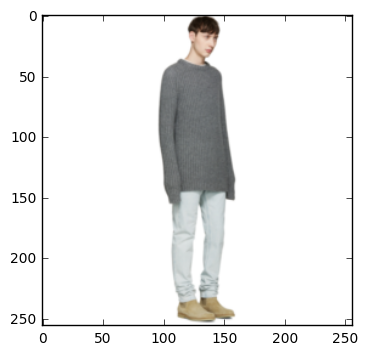

In [115]:
plt.imshow(img);
print("Raw text: \n%s\n" % text)
print("Normalized text: \n%s\n" %  normalize(text))
print("Normalized text with vocab: \n%s\n" % normalize(text, vocab))
plt.show()

## To be consistent with StackGAN

In [116]:
import scipy.misc

In [117]:
def clean_plot(img, size, dpi=60):
    plt.figure().set_size_inches(float(size)/float(dpi),float(size)/float(dpi))
    plt.xticks([]); plt.yticks([]);
    plt.imshow(img);

In [118]:
img_304 = scipy.misc.imresize(img, [BIG_SIZE, BIG_SIZE], 'bicubic')
img_76 = scipy.misc.imresize(img, [SMALL_SIZE, SMALL_SIZE], 'bicubic')

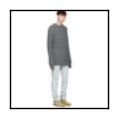

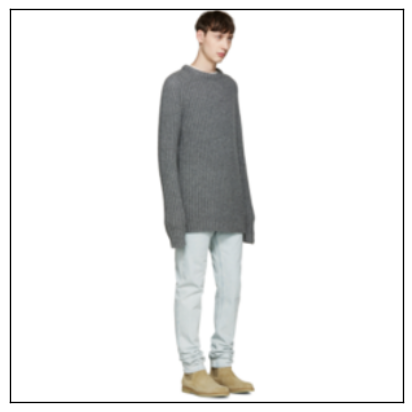

In [119]:
clean_plot(img_76, SMALL_SIZE) ; clean_plot(img_304, BIG_SIZE);